2015-01-02 17832.990234 1926.439941
2015-01-05 17501.650391 1915.75
2015-01-06 17371.640625 1882.449951
2015-01-07 17584.519531 1883.829956
2015-01-08 17907.869141 1904.650024
2015-01-09 17737.369141 1924.699951
2015-01-12 17640.839844 1920.949951
2015-01-13 17613.679688 1917.140015
2015-01-14 17427.089844 1913.660034
2015-01-15 17320.710938 1914.140015
2015-01-16 17511.570312 1888.130005
2015-01-20 17515.230469 1918.310059
2015-01-21 17554.279297 1921.22998
2015-01-22 17813.980469 1920.819946
2015-01-23 17672.599609 1936.089966
2015-01-26 17678.699219 1935.680054
2015-01-27 17387.210938 1952.400024
2015-01-28 17191.369141 1961.579956
2015-01-29 17416.849609 1951.02002
2015-01-30 17164.949219 1949.26001
2015-02-02 17361.039062 1952.680054
2015-02-03 17666.400391 1951.959961
2015-02-04 17673.019531 1962.790039
2015-02-05 17884.880859 1952.839966
2015-02-06 17824.289062 1955.52002
2015-02-09 17729.210938 1947.0
2015-02-10 17868.759766 1935.859985
2015-02-11 17862.140625 1945.699951
2015-

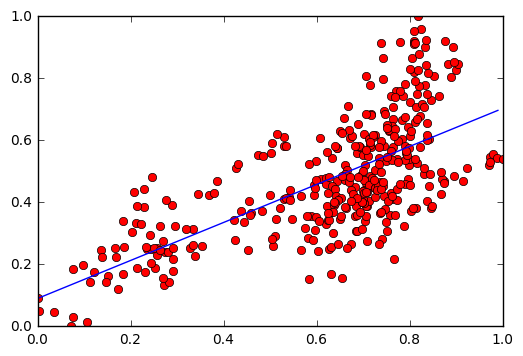

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

def make_train_data():
    start = datetime.datetime(2015,1,2)
    end = datetime.datetime(2016,7,22)
    f1 = web.DataReader("^DJI",'yahoo',start,end)
    f2 = web.DataReader("^KS11",'yahoo',start,end)
    dates = []
    x_data = []
    y_data = []
    for single_date in daterange(start, end):
        date_str = single_date.strftime('%Y-%m-%d')
        try:
                f1_close = f1.ix[date_str]['Close']
        except:
                continue
        try:
                f2_close = f2.ix[date_str]['Close']
        except:
                continue
        x_data.append(f1_close)
        y_data.append(f2_close)
        dates.append(date_str)
    return dates, x_data, y_data
                
def normalize(data):
    z_data = []
    min_data = min(data)
    max_data = max(data)
    for x in data:
        z_data.append( (x - min_data) / (max_data - min_data) )
    return z_data, max_data, min_data

# 프로그램 시작
PICKLE_FILE = 'data.pck'
import os.path
if os.path.isfile(PICKLE_FILE):
    f = open('data.pck', 'rb')
    dates, x_data, y_data = pickle.load(f)
else:
    dates, x_data, y_data = make_train_data()
    f = open('data.pck', 'wb')
    pickle.dump([dates, x_data, y_data], f)
f.close()

for i in range(len(dates)):
    print(dates[i], x_data[i], y_data[i])
 
# 데이터를 정규화(normalize) 합니다.
x_data, x_max, x_min = normalize(x_data)
y_data, y_max, y_min = normalize(y_data)

# Tensorflow에서 Gradient descent 알고리즘을 통해 cost최소가 되는 가설함수, h(x)를 찾습니다.
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 가설함수, h(x) 
hypothesis = W * X + b

# cost 함수.
cost = tf.reduce_mean(tf.square(hypothesis - Y))

# cost 최소값을 Gradient descent 알고리즘을 통해 찾습니다.
a = tf.Variable(0.1)	# Learning rate, alpha
optimizer = tf.train.GradientDescentOptimizer(a)
train = optimizer.minimize(cost)

# Before starting, initialize the variables, We will 'run' this first.
init = tf.initialize_all_variables()

# Launch the graph.
sess = tf.Session()
sess.run(init)

# Fit the line.
for step in range(2001):
    sess.run(train, feed_dict={X:x_data, Y:y_data})
    if step % 20 == 0:
        print(step, sess.run(cost, feed_dict={X:x_data, Y:y_data}), sess.run(W), sess.run(b))

# cost가 최소값이 되는 W,b를 출력.
print(sess.run(W), " * X + ", sess.run(b))

# 다우존스지수가 18313.77일 때 코스피지수 값을 예측합니다.
x_test = 18313.77
x_test_norm = (x_test - x_min) / (x_max - x_min)
y_test_norm = sess.run(hypothesis, feed_dict={X:x_test_norm})
y_test = y_test_norm * (y_max - y_min) + y_min
print('2016-08-02 DOW30 : ', x_test, x_test_norm)
print('2016-08-02 estimated KOSPI : ', y_test, y_test_norm)
print('2016-08-02 KOSPI : ', 2019.03)

# 그래프를 그립니다.
plt.plot(x_data, y_data, 'ro')
line_x = np.arange(min(x_data), max(x_data), 0.01)
plt.plot(line_x, sess.run(hypothesis, feed_dict={X:line_x}))
plt.show()